In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx # to support network visualisation and compute network statistics

In [2]:
#set random value - which can be adjusted
np.random.seed(35)

In [3]:
#parameters for brownian motion paths to simulate stock prices - which can be changed per user requirements
n_assets = 10 # number of assets in portfolio 
n_days = 20 # period
mu=0.01 # mean
sigma = 0.02  #volatility
initial_price = 100 

In [4]:
# Generate random daily returns for 5 assets (GBM)
returns = np.random.normal(mu, sigma, (n_days, n_assets))

# Convert returns to asset prices
prices = initial_price * np.exp(np.cumsum(returns, axis=0)) #brownian motion paths

# Compute daily returns from prices
daily_returns = np.diff(prices, axis=0) / prices[:-1]

# Convert to a DataFrame
returns_df = pd.DataFrame(daily_returns, columns=[f'Asset_{i+1}' for i in range(n_assets)])

In [5]:
returns_df.head()

,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_7,Asset_8,Asset_9,Asset_10
0,0.011121,-0.013538,-0.003517,0.006698,0.019537,0.016814,-0.006969,0.011439,0.010426,0.036978
1,0.033856,0.003199,0.011187,0.014623,0.002491,0.021290,-0.017267,0.030097,0.015899,-0.021707
2,0.003264,-0.006316,0.032098,0.018757,-0.014850,-0.003636,0.018874,0.035963,0.025478,0.009825
3,0.037040,0.033112,-0.004543,0.002788,0.019240,-0.001744,-0.049087,0.030090,-0.012266,0.006282
4,-0.013574,0.027808,-0.009208,0.013755,-0.036029,0.047351,0.047740,0.002465,0.017107,0.007704


We implement a sliding window to capture the dynamic nature of asset correlations as soley looking at the returns on one day is static . Currently, we have a sliding window of size 5 which can be changed.

In [6]:
# set window size
window = 5
#creating list to store correlation matrices
correlation_matrices_list=[] 

# Sliding through the returns to compute correlation matrices for each window.
for i in range(0,len(returns_df)+1-window):
    window_data = returns_df.iloc[i:i+window]
    correlation_matrices_list.append(window_data.corr())

Let us define a 'toy' correlation matrix to understand what we are working with

In [7]:
test_correlation_matrix = correlation_matrices_list[0]

In [8]:
test_correlation_matrix

,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_7,Asset_8,Asset_9,Asset_10
Asset_1,1.000000,0.086001,0.019534,-0.482591,0.788130,-0.545506,-0.952105,0.629625,-0.628417,-0.409504
Asset_2,0.086001,1.000000,-0.541889,-0.353943,-0.225090,0.241615,-0.104948,-0.164821,-0.579501,-0.323198
Asset_3,0.019534,-0.541889,1.000000,0.708381,-0.139190,-0.560623,0.103224,0.744503,0.585130,-0.256952
Asset_4,-0.482591,-0.353943,0.708381,1.000000,-0.725078,0.178778,0.687644,0.170214,0.924879,-0.381551
Asset_5,0.788130,-0.225090,-0.139190,-0.725078,1.000000,-0.584945,-0.899719,0.342673,-0.648772,0.223167
Asset_6,-0.545506,0.241615,-0.560623,0.178778,-0.584945,1.000000,0.625960,-0.841025,0.292968,-0.086137
Asset_7,-0.952105,-0.104948,0.103224,0.687644,-0.899719,0.625960,1.000000,-0.539252,0.778949,0.135873
Asset_8,0.629625,-0.164821,0.744503,0.170214,0.342673,-0.841025,-0.539252,1.000000,-0.073142,-0.444760
Asset_9,-0.628417,-0.579501,0.585130,0.924879,-0.648772,0.292968,0.778949,-0.073142,1.000000,-0.082127
Asset_10,-0.409504,-0.323198,-0.256952,-0.381551,0.223167,-0.086137,0.135873,-0.444760,-0.082127,1.000000


To construct the networks with Networkx, we use Adjacency Matrices. Adjacency matrices are square matrices of binary values where a matrix entry of "1" represents an edge between two nodes. 


In [9]:
#function to create adjacency matrix
def to_adj_matrix(test_correlation_matrix): 
    limit=0.3
    adj_matrix = test_correlation_matrix.copy()
    for i in range(test_correlation_matrix.shape[0]):
        for j in range(test_correlation_matrix.shape[1]):
            if abs(test_correlation_matrix.iloc[i,j])<limit:
                adj_matrix.iloc[i,j]=1
            else:
                adj_matrix.iloc[i,j]=0
    adj_matrix = adj_matrix.to_numpy()
    return adj_matrix

We store adjacency matrices in a list, which are then used to generate a corresponding list of networks. These networks can be iterated over to compute various network statistics


In [10]:
#function to create list of adjacency matrices from list of correlation matrices

def to_adj_matrices_list(correlation_matrices_list):
    adj_matrices_list=[]
    for matrix in correlation_matrices_list:
        adj_matrices_list.append(to_adj_matrix(matrix))
    return adj_matrices_list

In [11]:
#calling the function to define the list of adjacency matrices
adj_matrix_list=to_adj_matrices_list(correlation_matrices_list)

In [12]:
#visualise an adjacency matrix - this is the adjacency matrix of the test_correlation_matrix defined above
test_adj_matrix = to_adj_matrix(test_correlation_matrix)
test_adj_matrix

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1., 1., 1., 0., 1., 0.]])

In [13]:
#function to create single graph from single adjacency matrix
def to_graph(test_adj_matrix): #function to draw graphs
    G = nx.from_numpy_array(test_adj_matrix)
    plt.figure(figsize=(5, 5))  # Optional: Adjust the size of the plot
    nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
    plt.show()
    return G


In [14]:
#function to create a list of graphs - in a future iteration, this will be changed to a dictionary for quicker access
def to_graphs_list(adj_matrix_list):
    graphs_list=[]
    for matrix in adj_matrix_list:
        graphs_list.append(to_graph(matrix))
    return graphs_list
    print(graphs_list)

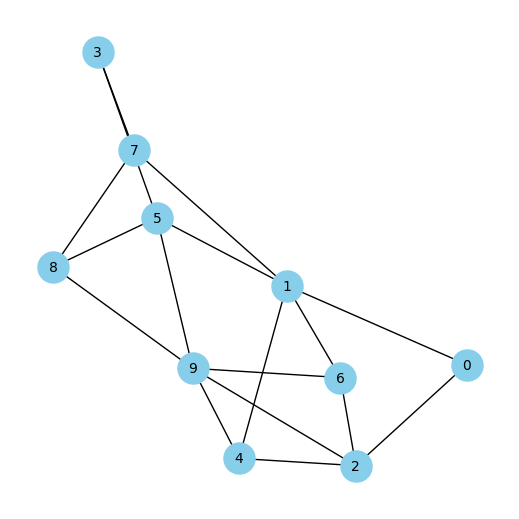

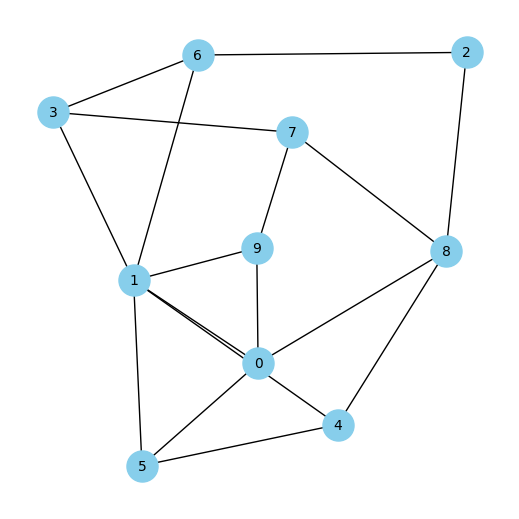

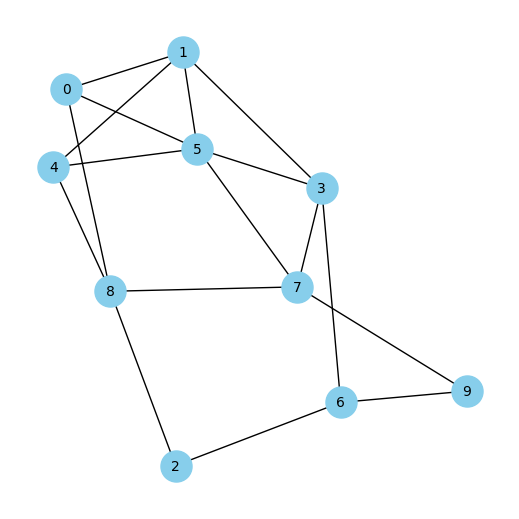

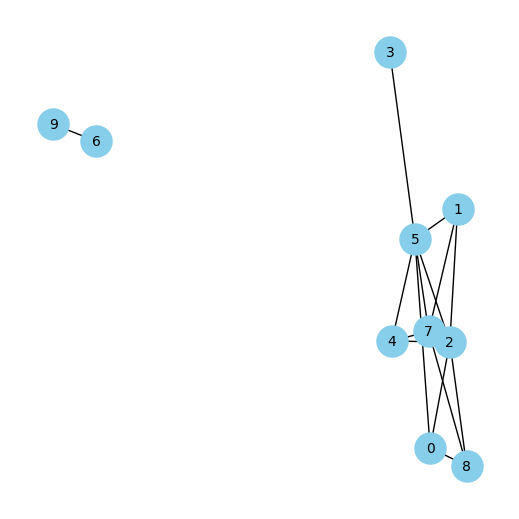

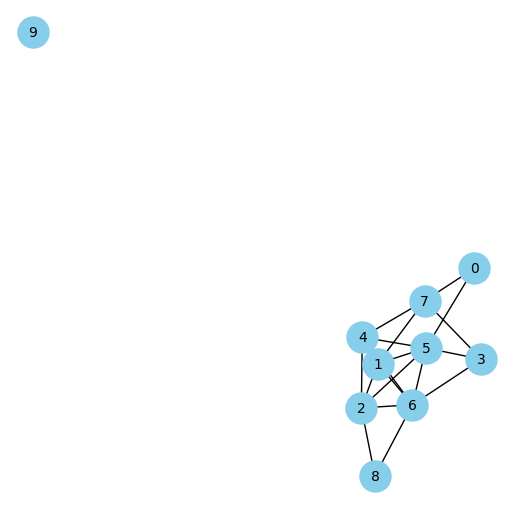

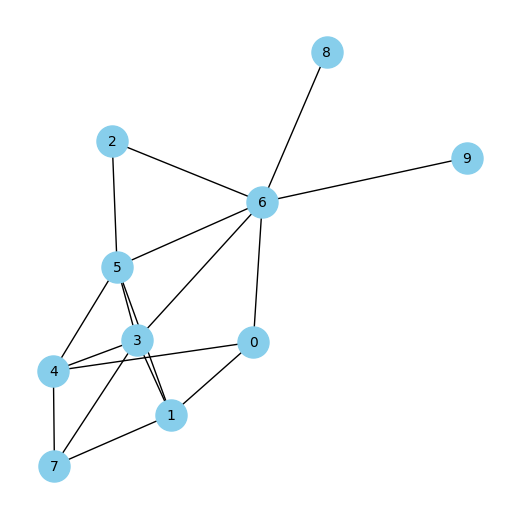

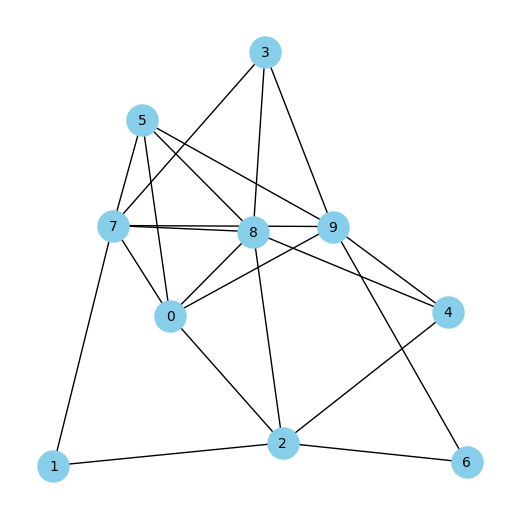

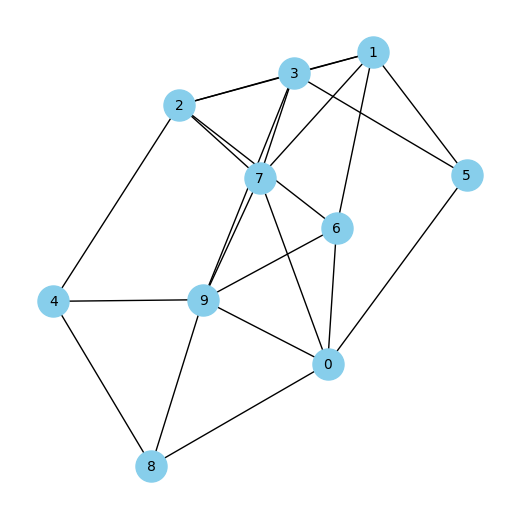

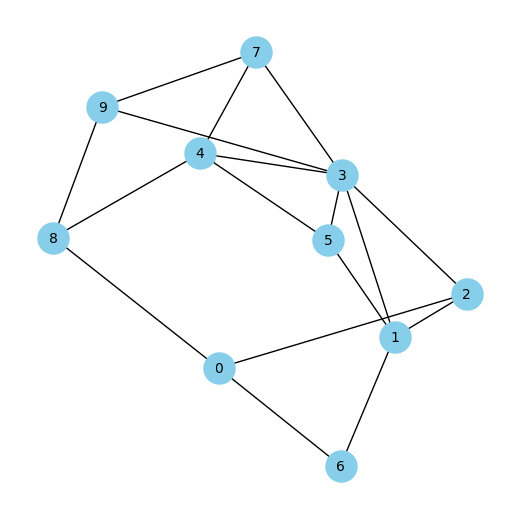

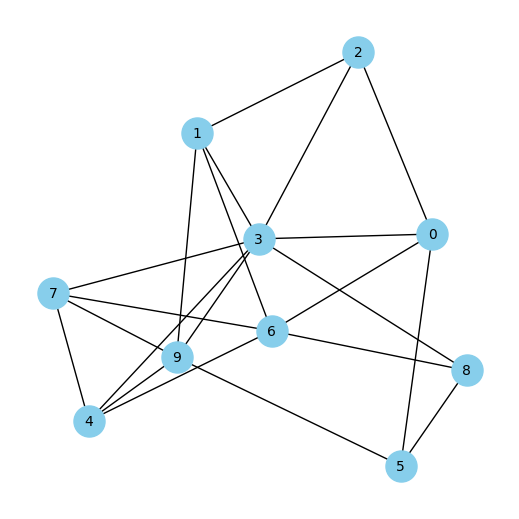

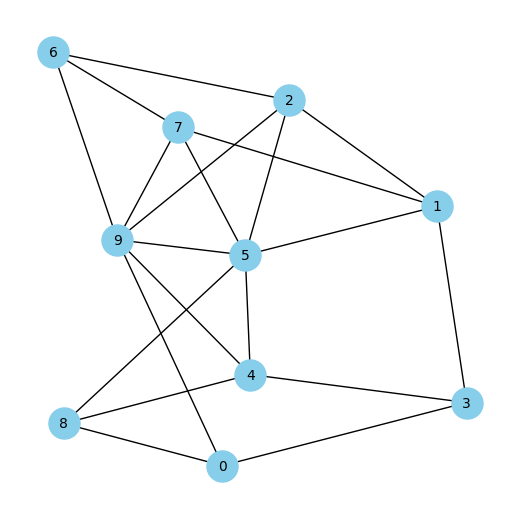

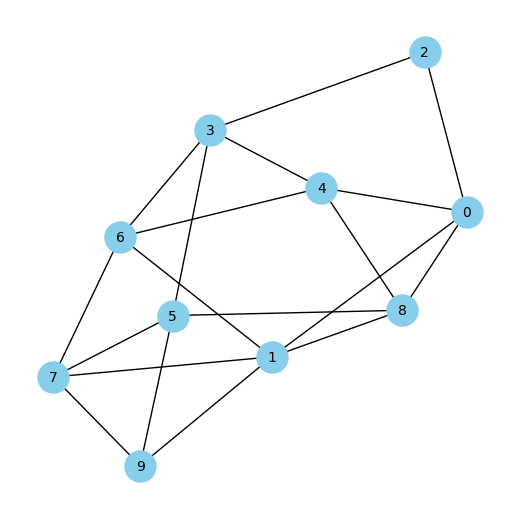

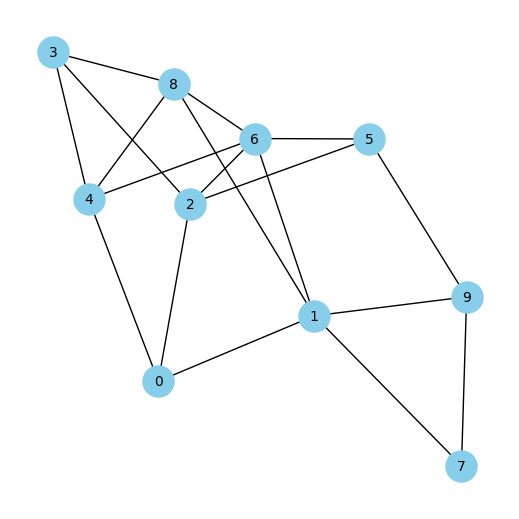

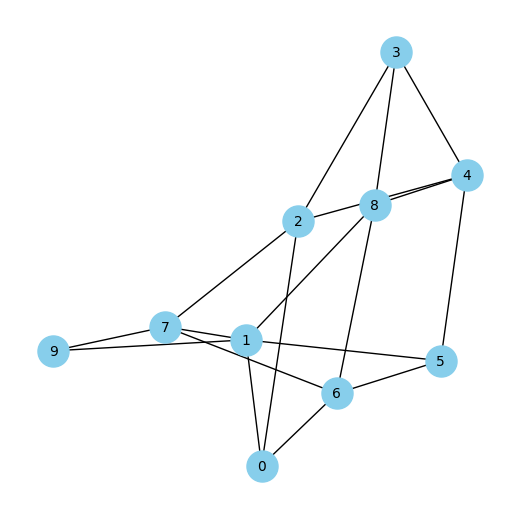

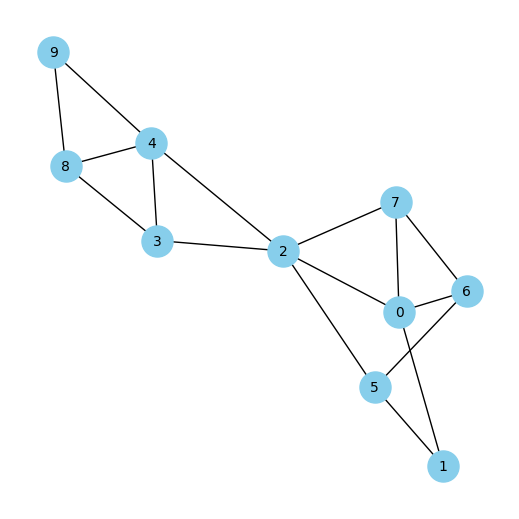

In [15]:
#calling the function to define the list of graphs
graphs=to_graphs_list(adj_matrix_list)

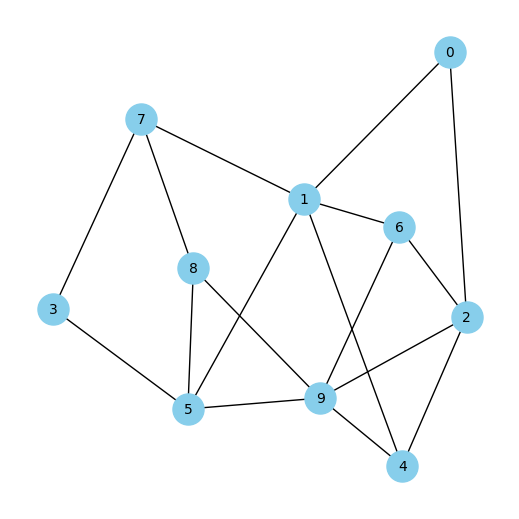

In [16]:
#creating test graph to play/test with and to visualise graph from test adjacency matrix above:
test_graph=to_graph(test_adj_matrix)

The first graph statistics/property we look at is Average Clustering Coefficient.

The average clustering coefficient measures the degree to which nodes in a network tend to cluster together, indicating how connected an asset's neighbors are to each other

In an Erdős–Rényi (ER) random graph, the average clustering coefficient is typically low, close to 0, because in random graphs, neighbors of a node are unlikely to be connected to each other. So if our empirical values are close to the ER values, which we will see in a plot, there is low clustering in the portfolio. Low clustering implies less asset return dependence so truer diversity or no hidden risk concentrations. 

In [17]:


#function to store the clustering coefficient of each graph in a list

def to_average_clustering_coeff_list(graph_list):
        average_clustering_coeff_list=[]
        for graph in graph_list:
            average_clustering_coeff_list.append(nx.average_clustering(graph))
        return average_clustering_coeff_list
    
#calling the function to define the list of clustering coefficients    
average_clustering_coeff_list = to_average_clustering_coeff_list(graphs)

In [18]:
#function to calculate Average Clustering Coefficient for the Erdos-Renyi (ER) graphs

def ER_average_clustering_coefficient(graph):
    m=graph.number_of_edges()
    n=graph.number_of_nodes()
    p=2*m/(n*(n-1))
    formula = p * (1 - (1 - p) ** (n - 1) - p * (n - 1) * (1 - p) ** (n - 2))
    return formula

    
#function to store all ER Clustering coefficients in one list 
def ER_average_clustering_coefficient_list(list):
    ER_average_clustering_coefficient_list=[]
    for graph in list:
        ER_average_clustering_coefficient_list.append(ER_average_clustering_coefficient(graph))
    return ER_average_clustering_coefficient_list

#calling the function to define the list of ER clustering coefficients  

ER_average_clustering_coefficient_list = ER_average_clustering_coefficient_list(graphs)


We plot the empirical values against the ER graph values to understand what level of similarity we have.

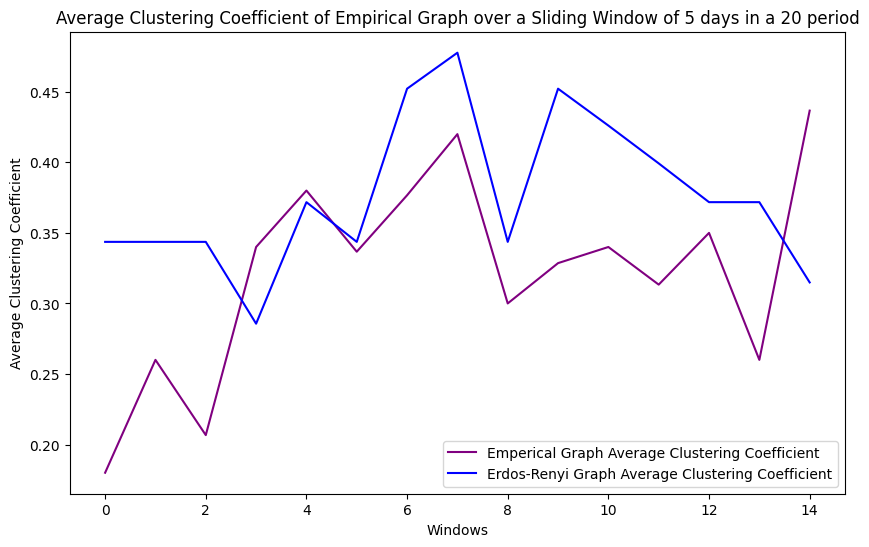

In [19]:
plt.figure(figsize=(10, 6))

values=[x for x in range(n_days-window)] #adjust later to be representative of windows

sns.lineplot(x= values, y=average_clustering_coeff_list, color='purple', label = 'Emperical Graph Average Clustering Coefficient')

sns.lineplot(x= values, y=ER_average_clustering_coefficient_list, color='blue', label='Erdos-Renyi Graph Average Clustering Coefficient')

plt.xlabel('Windows')
plt.ylabel('Average Clustering Coefficient') 
plt.title(f'Average Clustering Coefficient of Empirical Graph over a Sliding Window of {window} days in a {n_days} period') #fix
plt.legend()

plt.show()

The next step in this analysis is to quantify the similarities or differences between the two plots, for example, by calculating the absolute difference (the measurable distance between corresponding points on the purple and blue plots) or using metrics like KL-Divergence. These differences will then be analysed and backtested to determine their financial significance, with the goal of creating a risk alert system.

The final goal would be for the points of intersection to be alerted beforehand.